In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

# Curve Fitting

This notebook shows how to extract meaning from the data you'll collect during week-1. It's very "cook book" because you're just learning the tools. Once we become familiar with the tools the guidance will be more general and less scaffolded. 

## Experiment 1

Here's a scenario. You collect some data in the lab, maybe some voltages measured at different points in a resistor network, like this:

In [17]:
df_resist = pd.read_csv('data/starter.csv')
df_resist.head()

,j,vdac,v1,v2,time
0,0,0.000000,0.097990,0.062994,0.398895
1,5,0.064656,0.137972,0.064958,0.801971
2,10,0.129361,0.195981,0.093962,1.205230
3,15,0.194067,0.253989,0.131980,1.607910
4,20,0.258773,0.316983,0.169998,2.010410


Let's take a quick look at this data:

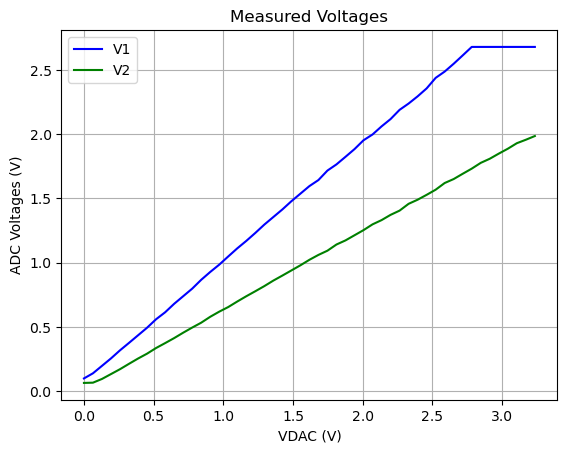

In [18]:
plt.plot(df_resist['vdac'], df_resist['v1'], 'b-', label='V1')
plt.plot(df_resist['vdac'], df_resist['v2'], 'g-', label='V2')
plt.title('Measured Voltages')
plt.xlabel('VDAC (V)')
plt.ylabel('ADC Voltages (V)')
plt.grid()
plt.legend()
plt.show()

The key idea of a voltage divider is that the ratio of voltages across the resistors in the divider is equal to the ratio of resistances. This implies that:

$$ \frac{v_2}{v_1} = \frac{R_2}{R_1+R_2} $$

So we expect a graph of $v_2$ vs $v_1$ would have a slope of $R_2$ divided by $R_1 + R_2$. Since we know these resistances, we can both predict, and measure, this slope. Let's do that. We'll use the [`scipy`](https://docs.scipy.org/doc/scipy/index.html) [`curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) function to do so. 

The [`curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) function takes a [python function](https://allendowney.github.io/ThinkPython/chap03.html), plus data for an independent and dependent variable, plus some optional information, like the uncertainty in the data, to estimate parameters of the function.

How can we use `curve_fit` to find the slope? First we need to define the function that describes the relationship we believe the data obeys, like this:

In [19]:
def fit_func(x, m, b):
    return m * x + b

Let's plot $v_2$ vs $v_1$ to see how that appears:

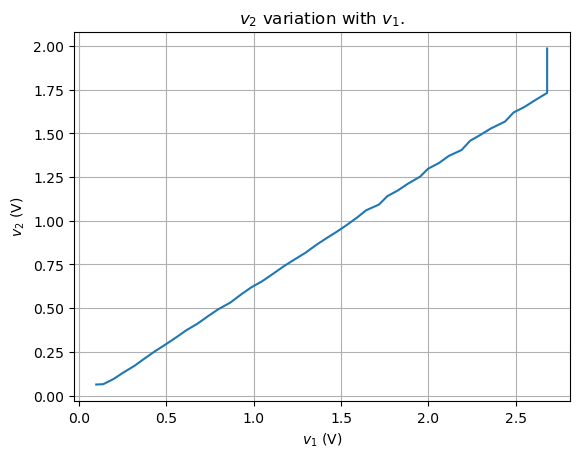

In [20]:

plt.plot(df_resist['v1'], df_resist['v2'])
plt.title('$v_2$ variation with $v_1$.')
plt.xlabel('$v_1$ (V)')
plt.ylabel('$v_2$ (V)')
plt.grid()
plt.show()

Note that things are not well behaved when $v_1$ is less than $0.2\mathrm{~V}$ or greater than $2.6\mathrm{~V}$. We can use array slicing to remove those.

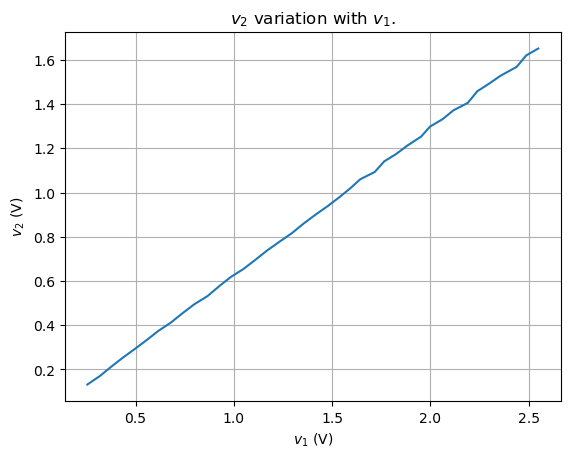

In [21]:
ok_range = (df_resist['v1'] > 0.2) & (df_resist['v1'] < 2.6)

plt.plot(df_resist['v1'][ok_range], df_resist['v2'][ok_range])
plt.title('$v_2$ variation with $v_1$.')
plt.xlabel('$v_1$ (V)')
plt.ylabel('$v_2$ (V)')
plt.grid()
plt.show()

Now let's use the `curve_fit` function to extract the slope: We know the ADCs on the ESP32-S2s are not fantastic, so as a guess we'll put in an uncertainty of $10\mathrm{~mV}$

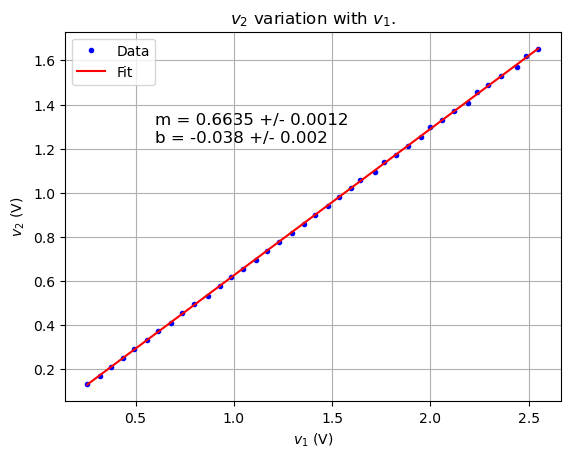

In [22]:
par, cov = curve_fit(fit_func, df_resist['v1'][ok_range], df_resist['v2'][ok_range], sigma=0.01)        
m,b = par
dm, db = np.sqrt(np.diag(cov))

fstr = f'm = {m:.4f} +/- {dm:.4f}\nb = {b:.3f} +/- {db:.3f}'

plt.plot(df_resist['v1'][ok_range], df_resist['v2'][ok_range], 'b.', label='Data')
plt.plot(df_resist['v1'][ok_range], fit_func(df_resist['v1'][ok_range], m, b), 'r-', label='Fit')
plt.title('$v_2$ variation with $v_1$.')
plt.text(0.6, 1.23, fstr, fontsize=12)
plt.xlabel('$v_1$ (V)')
plt.ylabel('$v_2$ (V)')
plt.grid()
plt.legend()
plt.show()

In [23]:
print(fstr)
R1=1e3
R2=2e3

m_exp = R2/(R1+R2)
print(f"m (expected) = {m_exp:.4f}")

m = 0.6635 +/- 0.0012
b = -0.038 +/- 0.002
m (expected) = 0.6667


Note that we get both a *value* and an *uncertainty* for the slope from `curve_fit`.

## Experiment 2

In this experiment you charge a capacitor and then measured the voltage as it discharged through the parallel combination of $R_1$ and $R_2$. First let's compute that:

$$R_{\rm eff} = \frac{R_1 R_2}{R_1+R_2} \approx 667\mathrm{\Omega} $$

From PHYS-163 you know that the voltage on the capacitor is expected to be:

$$ V(t) = V_0 e^{-t/\tau} $$

Where $\tau$ is the time constant: $\tau = R_{\rm eff} C$. This is an exponential graph that more or less matches the data:

In [24]:
df_decay = pd.read_csv('data/decay.csv')
df_decay.head()

,j,v1,v2,v3,time
0,0,0.060980,0.060980,1.96796,0.002045
1,2,0.057958,0.058965,1.91298,0.003906
2,4,0.056951,0.055995,1.86096,0.005707
3,6,0.054987,0.055995,1.81096,0.007538
4,8,0.052973,0.052973,1.76196,0.009338


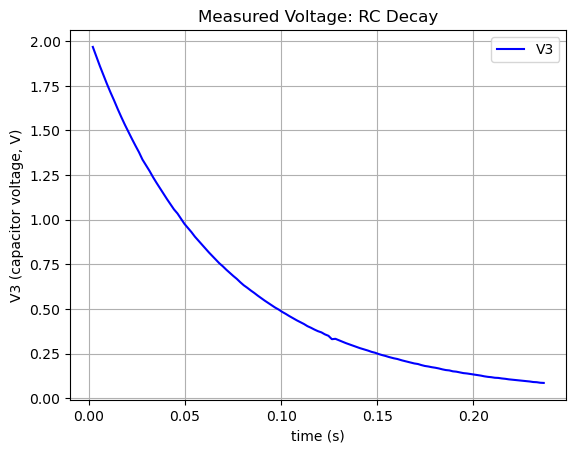

In [25]:
plt.plot(df_decay['time'], df_decay['v3'], 'b-', label='V3')
plt.title('Measured Voltage: RC Decay')
plt.xlabel('time (s)')
plt.ylabel('V3 (capacitor voltage, V)')
plt.grid()
plt.legend()
plt.show()

We could use `curve_fit` to perform this fit, but it's also useful to linearize the problem so we can use a linear fit. Let's do that. If we take the log of both sides of the decay formula we get:

$$ \ln(V(t)) = \ln(V_0) - t/\tau) $$

which is a simple linear relationship. Let's look at that, and then fit it.

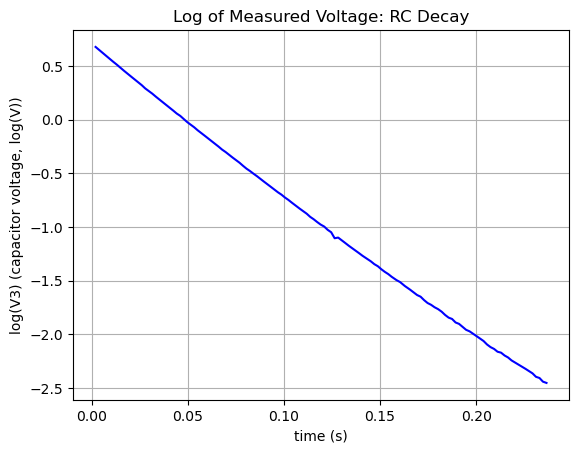

In [26]:
plt.plot(df_decay['time'], np.log(df_decay['v3']), 'b-', label='log(V3)')
plt.title('Log of Measured Voltage: RC Decay')
plt.xlabel('time (s)')
plt.ylabel('log(V3) (capacitor voltage, log(V))')
plt.grid()

Wow! That looks pretty darn straight! Let's fit it.

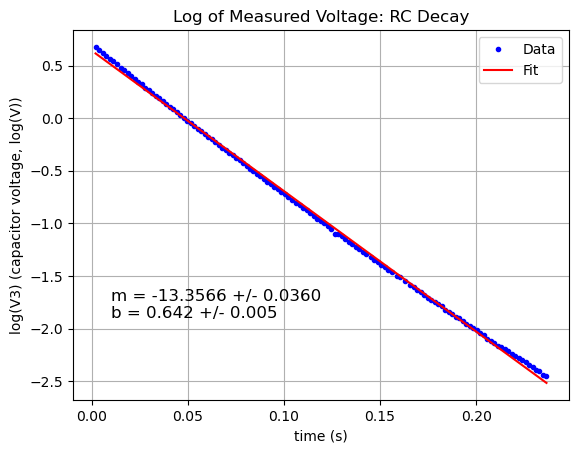

In [27]:
par, cov = curve_fit(fit_func, df_decay['time'], np.log(df_decay['v3']), sigma=0.01)
m,b = par
dm, db = np.sqrt(np.diag(cov))

fstr = f'm = {m:.4f} +/- {dm:.4f}\nb = {b:.3f} +/- {db:.3f}'

plt.plot(df_decay['time'], np.log(df_decay['v3']), 'b.', label='Data')
plt.plot(df_decay['time'], fit_func(df_decay['time'], m, b), 'r-', label='Fit')
plt.title('Log of Measured Voltage: RC Decay')
plt.xlabel('time (s)')
plt.ylabel('log(V3) (capacitor voltage, log(V))')
plt.text(0.01, -1.9, fstr, fontsize=12)
plt.grid()
plt.legend()
plt.show()


This fit is not quite as clear as the resistive fit, but it's not bad! From the slope, can we estimate $\tau$? Sure!

In [28]:
tau = -1/m
tau_max = -1/(m-2*dm)
C = 100e-6 # 100 uF
R = R1*R2/(R1+R2)
tau_exp = R*C
print(f"tau = {tau:.3e} +- {tau_max-tau:.3e}")
print(f"tau_exp = {tau_exp:.3e}")


tau = 7.487e-02 +- -4.009e-04
tau_exp = 6.667e-02


Nonetheless, it's a reasonable result.